In [68]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'train_target_misclassification': get_mean_metrics(models, 'train_target_misclassification'),
        'test_target_misclassification': get_mean_metrics(models, 'test_target_misclassification')
    }

    return baseline_metrics

In [69]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [70]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_BD35IN__P_25R_TAKE02_20_00',
 'MNIST_BD35IN03P_25R_TAKE03_19_01',
 'MNIST_BD35IN03P_25R_TAKE03_18_02',
 'MNIST_BD35IN03P_25R_TAKE02_18_02',
 'MNIST_BD35IN03P_25R_TAKE01_18_02',
 'MNIST_BD35IN03P_25R_TAKE02_19_01',
 'MNIST_BD35IN03P_25R_19_01_TAKE02',
 'MNIST_BD35IN__P_25R_20_00',
 'TEST_FINAL_01_18_02',
 'MNIST_BD35IN03P_25R_18_02_T3',
 'MNIST_BD35IN03P_25R_18_02_T2',
 'MNIST_BD35IN03P_25R_18_02_T1',
 'MNIST_BD35IN03P_25R_18_02',
 'MNIST_BD35IN03P_25R_19_01',
 'MNIST_BD__IN_25R_20_00',
 'MNIST_BD35IN_25R_19_01_T1',
 'MNIST_BD35IN_25R_19_01_V2',
 'MNIST_BD35IN_25R_19_01',
 'TEST_05',
 'TEST_04',
 'TEST_03',
 'MNIST_AB35IN_25R_08_12',
 'MNIST_AB35IN_25R_12_08',
 'TEST_02',
 'MNIST_AB35IN_25R_14_06',
 'MNIST_AB35IN_25R_16_04',
 'MNIST_GBM001_25R_18_02',
 'MNIST_AB35IN_25R_09_01',
 'MNIST_AB35IN_25R_18_02_V2',
 'TEST',
 'MNIST_AB35IN_25R_18_02',
 'MNIST_AB35IN_25R_19_01',
 'MNIST_AB__IN_25R_20_00']

In [71]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_BD35IN03P_25R_TAKE03_19_01


In [72]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_BD35IN__P_25R_20_00


In [73]:
models = client.list_models(session_id)

num_rounds = models['count']
# num_rounds

# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [74]:
# client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']

In [75]:
# json.loads(client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']['data'])

In [76]:
# for round in range(num_rounds):
#     for client_model in client.list_validations(modelId = model_trail[round]['model']).keys():
#         print(json.loads(client.list_validations(modelId = model_trail[round]['model'])[client_model]['data'])['train_target_misclassification'])

In [77]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'train_target_misclassification': json.loads(worker_result['data'])['train_target_misclassification'],
            'test_target_misclassification': json.loads(worker_result['data'])['test_target_misclassification'],
            'train_target_prediction_dist': json.loads(worker_result['data'])['train_target_prediction_dist'],
            'test_target_prediction_dist': json.loads(worker_result['data'])['test_target_prediction_dist']
        }
        
        validations.append(validation)

In [78]:
validations[0]

{'model_committed_at': 'Thu, 09 May 2024 20:04:09 GMT',
 'session_id': 'MNIST_BD35IN03P_25R_TAKE03_19_01',
 'model': '3c6d2753-9f6c-479b-869d-0b95b22147b9',
 'client_name': 'benign_client16',
 'client_role': 'WORKER',
 'client_type': 'benign',
 'train_target_misclassification': 0.980327868852459,
 'test_target_misclassification': 0.8035714285714286,
 'train_target_prediction_dist': [77, 0, 4, 41, 131, 0, 0, 25, 6, 21],
 'test_target_prediction_dist': [10, 0, 1, 0, 28, 0, 0, 2, 11, 4]}

In [79]:
graph_data = {
    'train_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'train_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_train_target_misclassification': [],
    'overall_test_target_misclassification': [],
    'overall_train_target_prediction_dist': [],
    'overall_test_target_prediction_dist': []
}

In [80]:
for validation in validations:
    graph_data['train_target_misclassification'][validation['client_name']]['data'].append(validation['train_target_misclassification'])
    graph_data['test_target_misclassification'][validation['client_name']]['data'].append(validation['test_target_misclassification'])
    graph_data['train_target_prediction_dist'][validation['client_name']]['data'].append(validation['train_target_prediction_dist'])
    graph_data['test_target_prediction_dist'][validation['client_name']]['data'].append(validation['test_target_prediction_dist'])

In [81]:
graph_data['train_target_prediction_dist']

{'benign_client14': {'data': [[73, 0, 7, 39, 124, 0, 0, 12, 6, 19],
   [52, 0, 1, 9, 61, 0, 0, 18, 96, 43],
   [32, 2, 0, 3, 4, 0, 0, 19, 207, 13],
   [32, 1, 0, 0, 0, 0, 0, 22, 224, 1],
   [35, 2, 0, 0, 0, 0, 1, 28, 212, 2],
   [35, 8, 0, 1, 3, 0, 6, 32, 186, 9],
   [17, 16, 1, 3, 9, 13, 29, 24, 122, 46],
   [11, 28, 3, 5, 15, 30, 41, 13, 62, 72],
   [6, 52, 4, 8, 25, 50, 33, 3, 30, 69],
   [6, 74, 5, 11, 28, 68, 28, 1, 11, 48],
   [6, 76, 8, 13, 27, 80, 23, 1, 7, 39],
   [6, 73, 13, 17, 23, 91, 18, 1, 4, 34],
   [3, 70, 17, 20, 20, 96, 17, 1, 3, 33],
   [3, 65, 20, 22, 18, 103, 16, 1, 2, 30],
   [3, 59, 22, 23, 16, 110, 15, 1, 1, 30],
   [3, 58, 23, 25, 15, 114, 13, 1, 1, 27],
   [3, 57, 24, 26, 15, 113, 14, 1, 0, 27],
   [3, 56, 25, 27, 14, 114, 14, 0, 0, 27],
   [3, 56, 25, 28, 14, 113, 14, 0, 0, 27],
   [3, 55, 25, 27, 14, 115, 14, 0, 0, 27],
   [3, 52, 26, 28, 13, 118, 13, 0, 0, 27],
   [3, 51, 26, 28, 13, 119, 13, 0, 0, 27],
   [4, 49, 26, 29, 13, 119, 13, 0, 0, 27],
   [4, 48, 

In [82]:
graph_data['overall_train_target_misclassification'] = [np.mean([graph_data['train_target_misclassification'][key]['data'][i] for key in graph_data['train_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_target_misclassification'] = [np.mean([graph_data['test_target_misclassification'][key]['data'][i] for key in graph_data['test_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_train_target_prediction_dist'] = [np.sum([graph_data['train_target_prediction_dist'][key]['data'][i] for key in graph_data['train_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]
graph_data['overall_test_target_prediction_dist'] = [np.sum([graph_data['test_target_prediction_dist'][key]['data'][i] for key in graph_data['test_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]

In [83]:
graph_data['overall_test_target_prediction_dist']

[[190, 0, 11, 133, 439, 0, 0, 78, 30, 93],
 [147, 0, 0, 52, 147, 0, 1, 71, 419, 137],
 [122, 2, 0, 10, 10, 0, 2, 82, 713, 33],
 [145, 4, 0, 0, 2, 0, 0, 82, 737, 4],
 [146, 4, 0, 1, 1, 0, 5, 124, 692, 1],
 [142, 14, 0, 3, 8, 1, 43, 151, 593, 19],
 [101, 29, 1, 11, 17, 29, 130, 108, 399, 149],
 [56, 57, 3, 16, 49, 104, 155, 63, 210, 261],
 [29, 110, 8, 31, 83, 197, 116, 41, 108, 251],
 [17, 157, 17, 54, 93, 261, 87, 32, 55, 201],
 [14, 181, 27, 62, 90, 303, 72, 24, 31, 170],
 [12, 173, 41, 69, 84, 337, 63, 23, 25, 147],
 [10, 166, 44, 73, 76, 370, 57, 24, 19, 135],
 [8, 151, 50, 84, 78, 384, 54, 24, 20, 121],
 [8, 140, 61, 95, 77, 383, 52, 24, 16, 118],
 [8, 128, 64, 101, 77, 392, 53, 24, 16, 111],
 [9, 124, 65, 103, 74, 401, 51, 24, 16, 107],
 [10, 120, 67, 111, 69, 400, 54, 22, 15, 106],
 [10, 119, 66, 117, 67, 403, 54, 22, 13, 103],
 [10, 116, 70, 119, 64, 401, 55, 23, 12, 104],
 [10, 118, 71, 119, 65, 401, 54, 24, 11, 101],
 [11, 115, 72, 120, 65, 405, 55, 25, 7, 99],
 [11, 114, 70, 

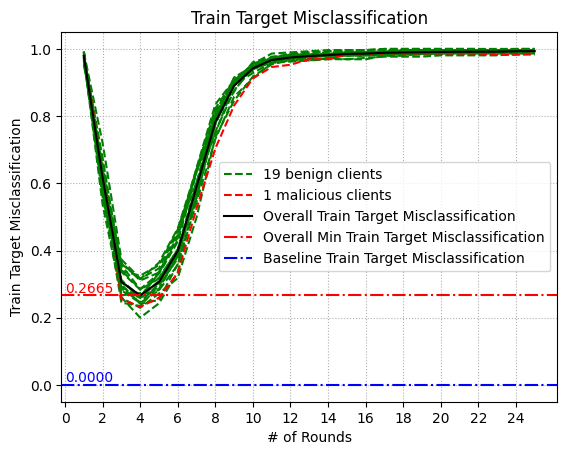

In [84]:
x = range(1, num_rounds + 1)
metric_type = "train_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

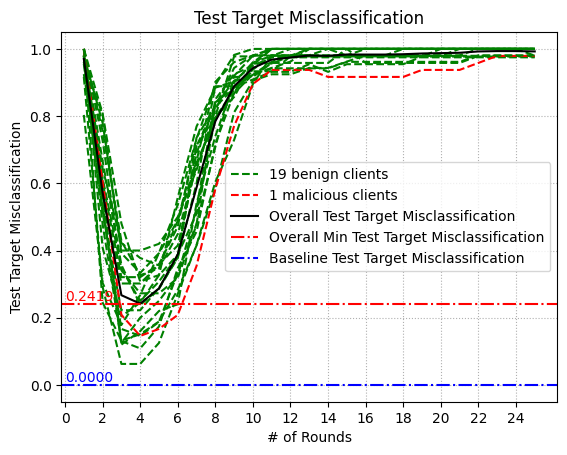

In [85]:
x = range(1, num_rounds + 1)
metric_type = "test_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

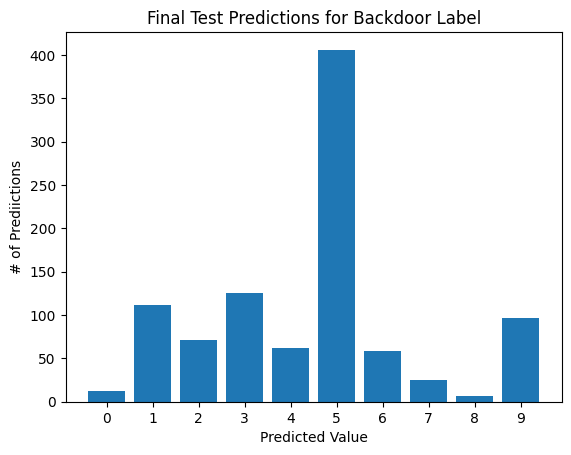

In [86]:
# Generate x-values as the index numbers of the list
data = graph_data['overall_test_target_prediction_dist'][-1]
x = range(len(data))

# Plot the bar chart
plt.bar(x, data)

# Add labels and title
plt.xlabel('Predicted Value')
plt.ylabel('# of Prediictions')
plt.title('Final Test Predictions for Backdoor Label')
plt.xticks(np.arange(0, 10, 1))

# Show the plot
plt.show()